  GAN在近幾年來，蓬勃發展，臉書的AI大師Yann LeCun說了:「This, and the variations that are now being proposed is the most interesting idea in the last 10 years in ML, in my opinion.」，大家好像都需要這酷東西。
在上一篇中我粗淺的介紹了vanilla GAN，最後的小結說了，其實GAN是個非常敏感的model，生成器一言不合就會開始沒意義的輸出，也就是說要能用GAN把圖片調整到看起來還可以其實是非常耗精氣神的(simple GAN那篇我調了兩個晚上)，這裡就要介紹給大家在生成圖片上一個更好用的寶貝，DCGAN。

DCGAN，全名 DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS。是Alec Radford & Luke Metz在2016年所提出的。
GAN通常是用在無監督學習(unsupervised learning)的model，無監督學習就是不需要標註資料，給機器一張狗的圖片，不需要再告訴他這是狗，CNN則是在有監督學習(supervised learning)上表現較佳。不熟CNN的人可以先看寫得非常好的這篇_____，建議先了解CNN後再繼續往下閱讀。


DCGAN以GAN的作為基礎概念做出一些架構上的改變，那麼要怎麼把GAN跟CNN結合起來呢？原論文中將
Discriminator(判別器)將裡頭的神經網路換成卷積神經網路(convolution neural network),Generator(生成器)則是換成逆卷積神經網路(transposed convolution neural network)，也就是利用CNN優秀的圖片判讀能力做判別器，再用transposed CNN當作生成器。

概念聽起來滿簡單的，但是魔鬼藏在細節裡，再讓我們來細看一下paper，到底還有什麼厲害的地方。

*以下如果有需要解釋的觀念，會附上一些連結，不知道的可以點進去看

DCGAN不單單只使用了CNN而已，還一些結構上的改變以提高的品質和收斂的速度：

1.  取消所有pooling層。在生成器中使用逆卷積神經網路做unsample(也就是圖片放大)，判別器中用使用strided convolutions代替。([strided convolutions](https://www.coursera.org/lecture/convolutional-neural-networks/strided-convolutions-wfUhx))

2.  在生成器和判別器中均使用 [batch normalization](https://ithelp.ithome.com.tw/articles/10204106)
3.  去掉全連結層
4.  生成器中使用ReLU作为activate function，最後一層使用tanh
5.  判別器中使用LeakyReLU作为activate function,斜率為0.2

要注意的一點是如果所有的layer都使用batch normalization容易讓sample和model不穩定，所以在生成器的輸出層和判別器的輸入層並沒有使用batch normalization。

除此之外還有，還有其他細節，像是：
1.  將圖片通過tanh(scale至[-1, 1])
2.  所有的初始參數從正態分佈 mean = 0, std= 0.02取得
3.  使用Adam optimizer
4.  learning rate=0.0002
5.  momentum的beta設為0.5

上述所說的會在操作中再次細講，各位可先稍微看過即可

下圖是原paper所畫GCGAN的生成器的圖,

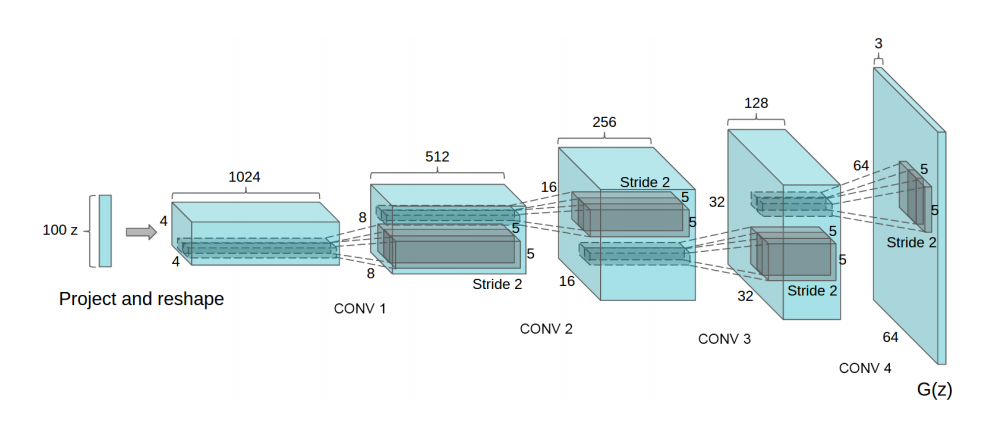

圖中是將一個100維的分佈z，透過feature maps，最後擴張成64 × 64 pixel的圖片，就是transposed CNN的運作方式，注意generator並沒有使用池化層(pooling layer)或是全連結層(fully connected layer)

到此就看得出來，不只是DCGAN的想法，Alec Radford & Luke Metz也展現出高超的調整參數能力，這裡就簡單的介紹，非常推薦大家去看原paper，裡面還有用濾鏡分析，空間探索等方法來證明DCGAN的強大，這裡就不一一贅述。

本次實作的部分，是採用李宏毅老師上課所介紹的二次元頭像的Database

以下是用pytorch實作的部分

In [1]:
#faces.tar.gz
!gdown --id 11j_HC40a2t2q9ZtsLp4OPwF2xzhJCG1i

Downloading...
From: https://drive.google.com/uc?id=11j_HC40a2t2q9ZtsLp4OPwF2xzhJCG1i
To: /content/faces.tar.gz
168MB [00:01, 86.2MB/s]


In [2]:
!tar -xf faces.tar.gz

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import torch
import torch.nn as nn

In [5]:
class Discriminator(nn.Module):
  def __init__(self, input_dim, output_fea):
    super(Discriminator, self).__init__()
    self.discr = nn.Sequential(
         nn.Conv2d(input_dim, output_fea, kernel_size=4, stride=2, padding=1),# (3, 64, 64) -> (64, 32, 32)
         nn.LeakyReLU(0.2),
         self._block(output_fea, output_fea*2, 4, 2, 1),# (64, 32, 32) -> (128, 16, 16)
         self._block(output_fea*2, output_fea*4, 4, 2, 1),# (128, 16, 16) -> (256, 8, 8)
         self._block(output_fea*4, output_fea*8, 4, 2, 1),# (256, 8, 8) -> (512, 4, 4)
         nn.Conv2d(output_fea*8, 1, kernel_size=4, stride=2, padding=0),# (512, 4, 4) -> (1, 1, 1)
         nn.Sigmoid())

  def _block(self,input, output, kernel_size, stride, padding):
    return nn.Sequential(
    nn.Conv2d(input, output, kernel_size=kernel_size, 
              stride=stride, padding=padding, bias=False),
    nn.BatchNorm2d(output),
    nn.LeakyReLU(0.2, True))
  
  def forward(self, x):
        return self.discr(x)

  def d_weight_init(self, m):
    for m in self.modules():
      if isinstance(m, (nn.Conv2d,nn.BatchNorm2d)):
          nn.init.normal_(m.weight, mean=0, std=0.02)


In [6]:
class Generator(nn.Module):
  def __init__(self, noise_dim,img_size, output_fea,):
    super(Generator, self).__init__()
    self.gene = nn.Sequential(
        self._block(noise_dim, output_fea*8, 4, 1, 0),
        self._block(output_fea*8, output_fea*4, 4, 2, 1),
        self._block(output_fea*4, output_fea*2, 4, 2, 1),
        self._block(output_fea*2, output_fea, 4, 2, 1),
        nn.ConvTranspose2d(output_fea, img_size, kernel_size=4, stride=2, padding=1),
        nn.Tanh())

  def _block(self, input, output, kernel_size, stride, padding):

    return nn.Sequential(
           nn.ConvTranspose2d(input, output, kernel_size = kernel_size,
           stride = stride, padding = padding, bias =False),
           nn.BatchNorm2d(output),
           nn.ReLU(True))
  def forward(self, x):
    return self.gene(x)
  
  def g_weight_init(self, m):
    for m in self.modules():
        if isinstance(m, (nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight, mean=0, std=0.02)

In [7]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"

In [8]:
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64

In [13]:
img_dir = '/content/sample_data/'
transform = transforms.Compose([ transforms.ToTensor(),
                                  transforms.Resize(IMAGE_SIZE),
                                  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
dataset = datasets.ImageFolder(img_dir, transform=transform)
loader = DataLoader(dataset,batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory = True)

In [14]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

In [15]:
disc.apply(disc.d_weight_init)
print("加载判别器随机参数成功")
gen.apply(gen.g_weight_init)
print("加载生成器隨機参数成功")

加载判别器随机参数成功
加载生成器隨機参数成功


In [16]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(25, NOISE_DIM, 1, 1).to(device)

In [17]:
def train(disc, gen, start_ephoces,NUM_EPOCHS= 50):
  for epoch in range(start_ephoces ,NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
          print(
              f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
              Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

          with torch.no_grad():
            fake_img = gen(fixed_noise).reshape(-1,3,64,64)
            #儲存圖片
            save_image(fake_img.data, f'/content/gdrive/MyDrive/DCGAN_model/generated_pic/{epoch+1}_{batch_idx}-fake_img.png',nrow=5, normalize=True, scale_each=True)
    state_d = {'model':disc.state_dict(), 'optimizer':opt_disc.state_dict(), 'epoch':epoch} 
    state_g = {'model':gen.state_dict(), 'optimizer':opt_gen.state_dict(), 'epoch':epoch}
    torch.save(state_d, "/content/gdrive/MyDrive/DCGAN_model/discriminator_M.pth")
    torch.save(state_g, "/content/gdrive/MyDrive/DCGAN_model/generator_M.pth")


In [18]:
train(disc, gen, 0)

Epoch [1/50] Batch 0/262               Loss D: 0.6948, loss G: 0.7881
Epoch [1/50] Batch 100/262               Loss D: 0.0148, loss G: 4.1230
Epoch [1/50] Batch 200/262               Loss D: 0.0043, loss G: 5.4327
Epoch [2/50] Batch 0/262               Loss D: 0.0734, loss G: 5.8052
Epoch [2/50] Batch 100/262               Loss D: 0.5585, loss G: 1.6414
Epoch [2/50] Batch 200/262               Loss D: 1.0792, loss G: 4.0020
Epoch [3/50] Batch 0/262               Loss D: 0.3725, loss G: 3.3872
Epoch [3/50] Batch 100/262               Loss D: 0.7054, loss G: 4.5532
Epoch [3/50] Batch 200/262               Loss D: 0.3204, loss G: 2.6824
Epoch [4/50] Batch 0/262               Loss D: 0.3762, loss G: 2.1758
Epoch [4/50] Batch 100/262               Loss D: 0.8082, loss G: 3.7426
Epoch [4/50] Batch 200/262               Loss D: 0.3725, loss G: 2.8110
Epoch [5/50] Batch 0/262               Loss D: 0.2923, loss G: 3.2827
Epoch [5/50] Batch 100/262               Loss D: 0.3818, loss G: 2.8476
Ep

In [ ]:
import os

def resume_train():
 log_dir_d = '/content/gdrive/MyDrive/DCGAN_model/discriminator_M.pth'
 log_dir_g = '/content/gdrive/MyDrive/DCGAN_model/generator_M.pth'
 if os.path.exists(log_dir_d):
   checkpoint_d = torch.load(log_dir_d)
   disc.load_state_dict(checkpoint_d['model'])
   opt_disc.load_state_dict(checkpoint_d['optimizer'])
   start_epoch_d = checkpoint_d['epoch']
   print(f'discriminator加载 epoch {start_epoch_d} 成功！')
  
 else:
   print('discriminator not found')
 if os.path.exists(log_dir_g):
   checkpoint_g = torch.load(log_dir_g)
   gen.load_state_dict(checkpoint_g['model'])
   opt_gen.load_state_dict(checkpoint_g['optimizer'])
   start_epoch_g = checkpoint_g['epoch']
   print(f'generator加载 epoch {start_epoch_g} 成功！')
 
 else:
   print('generator not found')
 
 train(disc, gen, start_epoch_g,200)